In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from dark_emulator_public import dark_emulator
import os, sys, time
import matplotlib.pyplot as plt
from collections import OrderedDict as od
from pyhalofit import pyhalofit
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp2d, interp1d
from scipy.integrate import simps
from tqdm import tqdm
import hsc3x2pt

using dark_emulator at  /Users/sugiyamasunao/Documents/python_package/dark_emulator_public/dark_emulator/__init__.py


## power spectrum class

In [3]:
power_b1 = hsc3x2pt.power_b1_class()

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


In [4]:
%%time
power_b1.init_pklin(3.0)

CPU times: user 96.6 ms, sys: 3.36 ms, total: 99.9 ms
Wall time: 25.3 ms


In [5]:
%%time
power_b1.init_pkhalo()

CPU times: user 548 ms, sys: 11.6 ms, total: 559 ms
Wall time: 395 ms


In [6]:
%%time
k = np.logspace(-5.0, 3, 100)
pkhalo = power_b1.get_pkhalo_kz(k, 0.1)
pklin  = power_b1.get_pklin_kz(k, 0.1)

CPU times: user 4.89 ms, sys: 850 µs, total: 5.74 ms
Wall time: 5.1 ms


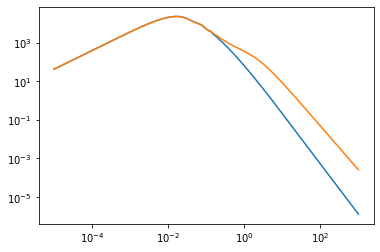

In [7]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e2,1e6)
plt.plot(k, pklin)
plt.plot(k, pkhalo)
plt.show()

$P\left(\frac{l}{\chi}, z(\chi)\right)$

In [8]:
l = 2e3
chimin, chimax = power_b1.z2chi(1e-4), power_b1.z2chi(3)
chi = np.logspace(np.log10(chimin), np.log10(chimax), 50)

In [9]:
%%time
pklin_lz = power_b1.get_pklin_lchi(l, chi)

CPU times: user 4.74 ms, sys: 338 µs, total: 5.08 ms
Wall time: 4.83 ms


In [10]:
%%time
pkhalo_lz = power_b1.get_pkhalo_lchi(l, chi)

CPU times: user 22.8 ms, sys: 3.21 ms, total: 26 ms
Wall time: 23.5 ms


In [11]:
%%time
pkhalogm_lz = power_b1.get_pkhalogm_lchi(l, chi, 4.0)

CPU times: user 19.9 ms, sys: 2.14 ms, total: 22.1 ms
Wall time: 20.4 ms


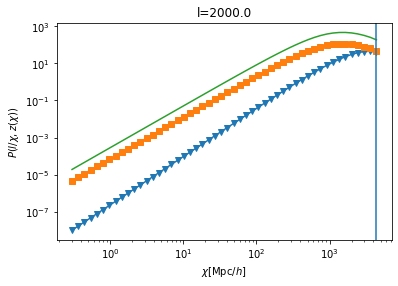

In [12]:
plt.figure()
plt.xlabel(r'$\chi[{\rm Mpc}/h]$')
plt.ylabel(r'$P\left(l/\chi, z(\chi)\right)$')
plt.title(f'l={l}')
plt.loglog(chi, pklin_lz, marker='v')
plt.loglog(chi, pkhalo_lz, marker='s')
plt.loglog(chi, pkhalogm_lz)#, marker='o')
plt.axvline(power_b1.chi_max)
plt.show()

## galaxy sample classes

In [13]:
g_l1 = hsc3x2pt.galaxy_sample_lens_class(['l1', 0.2, 0.2-0.01, 0.2+0.01, 2.1, 0.1, 2.3])
g_s1 = hsc3x2pt.galaxy_sample_source_class(['s1', 0.5, 0.2, 0.1])

In [14]:
cosmo_dict = power_b1.get_cosmo_dict()
g_l1.set_cosmology_from_dict(cosmo_dict)
g_s1.set_cosmology_from_dict(cosmo_dict)

chirange1 = g_l1.window_galaxy_chirange()
chirange2 = g_s1.window_lensing_chirange()

print(chirange1, chirange2)

[543.2862037  597.35429861] [  13.1496562 1301.815964 ]


In [15]:
g_l1.z_lens_eff

array(0.19983263)

In [16]:
hsc3x2pt.get_chirange_overlap(chirange1, chirange2)

array([543.2862037 , 597.35429861])

In [17]:
g_s1.sample_type

'source'

## $C(l)$ class

In [18]:
pk2cl = hsc3x2pt.pk2cl_class(power_b1)

In [19]:
pk2cl.set_cosmology_from_dict(cosmo_dict)
pk2cl.set_galaxy_sample(g_l1)
pk2cl.set_galaxy_sample(g_s1)
pk2cl.init_pk()

### $C(l)$ per single l

CPU times: user 55.4 ms, sys: 2.42 ms, total: 57.8 ms
Wall time: 56.1 ms


1.950968692801429e-07

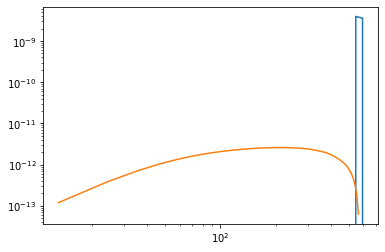

In [20]:
%%time
s1 = pk2cl.get_galaxy_sample('l1')
pk2cl._CgE(g_l1, g_s1, 100, model='nonlin', plot=True, plot_xlog=True)

CPU times: user 38.6 ms, sys: 2.05 ms, total: 40.7 ms
Wall time: 39 ms


1.123965200796944e-09

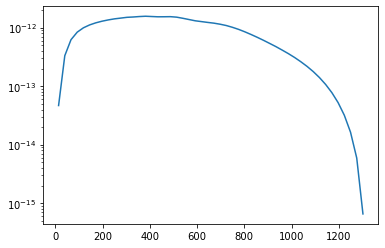

In [21]:
%%time
pk2cl._CEE(g_s1, g_s1, 100.0, model='nonlin', plot=True)

Cgg(l)                                =0.0005321748701783888
Cgg(l)+Cg,mag(l)                      =0.0005321848705815967
Cgg(l)+Cg,mag(l)+Cmag,g(l)            =0.0005321948709848046
Cgg(l)+Cg,mag(l)+Cmag,g(l)+Cmag,mag(l)=0.000532196514902018
CPU times: user 78.3 ms, sys: 3.08 ms, total: 81.3 ms
Wall time: 79.4 ms


0.000532196514902018

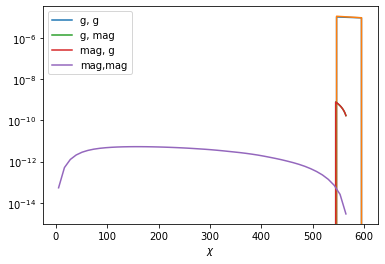

In [22]:
%%time
pk2cl._Cgg(g_l1, g_l1, 100.0, model='nonlin', plot=True)

### $C(l)$ as a function of $l$

lin:1.8822989463806152
nonlin:3.4109950065612793


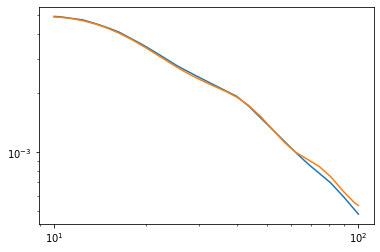

CPU times: user 5.63 s, sys: 75 ms, total: 5.7 s
Wall time: 5.71 s


In [23]:
%%time
l = np.logspace(1, 2.0, 1000)

plt.figure()
with hsc3x2pt.Time(message='lin'):
    clgg = pk2cl.Cgg('l1', 'l1', l, model='lin')
plt.loglog(l, clgg)
with hsc3x2pt.Time(message='nonlin'):
    clgg = pk2cl.Cgg('l1', 'l1', l, model='nonlin', plot=False)
plt.loglog(l, clgg)
plt.show()

lin:0.8714032173156738
lin:2.2336249351501465


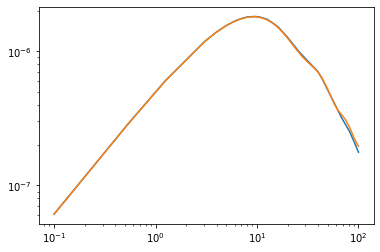

CPU times: user 3.73 s, sys: 64 ms, total: 3.79 s
Wall time: 3.81 s


In [24]:
%%time
l = np.logspace(-1, 2, 1000)

plt.figure()
with hsc3x2pt.Time(message='lin'):
    clgE = pk2cl.CgE('l1', 's1', l, model='lin')
plt.loglog(l, clgE)
with hsc3x2pt.Time(message='lin'):
    clgE = pk2cl.CgE('l1', 's1', l, model='nonlin')
plt.loglog(l, clgE)
plt.show()

lin:0.40805888175964355
lin:1.242429256439209


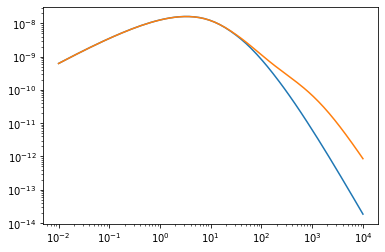

CPU times: user 2.54 s, sys: 38.8 ms, total: 2.58 s
Wall time: 2.59 s


In [25]:
%%time
l = np.logspace(-2, 4, 1000)

plt.figure()
t0 = time.time()
with hsc3x2pt.Time(message='lin'):
    clEE = pk2cl.CEE('s1', 's1', l, model='lin')
plt.loglog(l, clEE)
with hsc3x2pt.Time(message='lin'):
    clEE = pk2cl.CEE('s1', 's1', l, model='nonlin')
plt.loglog(l, clEE)
plt.show()

### compute all the $C(l)$

In [26]:
%%time
pk2cl.compute_all_Cl(l)

CPU times: user 6.22 s, sys: 65 ms, total: 6.28 s
Wall time: 6.29 s


In [27]:
pk2cl.dump_Cl_cache('temp_Cl', overwrite=True)

saving l to temp_Cl/l.txt
saving l1,l1 to temp_Cl/l1,l1.txt
saving l1,s1 to temp_Cl/l1,s1.txt
saving s1,s1 to temp_Cl/s1,s1.txt


In [80]:
pk2cl.load_Cl_cache('temp_Cl')

### Fourier-back transformation of signals

These functions need validation with brute-force method.

brute force:0.09021115303039551 sec
-4.0 3.0


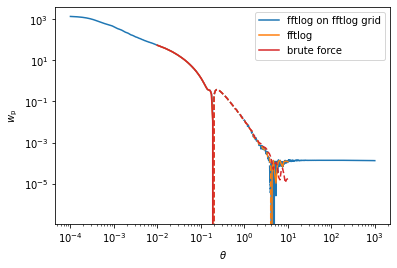

fftlog:0.7756781578063965 sec


In [100]:
t = np.logspace(-2, 1, 100)
with hsc3x2pt.Time(message='brute force'):
    ans = pk2cl.angular_correlation_function_bruteforce('l1', 'l1', t, 'wp')
with hsc3x2pt.Time(message='fftlog'):
    ans = pk2cl.angular_correlation_function_fftlog('l1', 'l1', t, 'wp', plot=True, 
                                                    plot_with=[{'xy':[t,ans],'c':'C3','label':'brute force'}])

brute force:0.08627486228942871 sec
-4.0 3.0


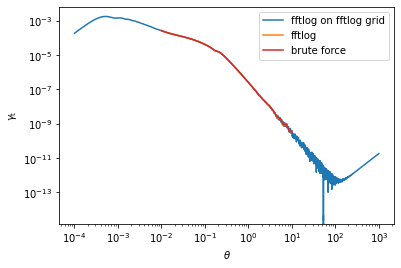

fftlog:0.9308772087097168 sec


In [101]:
t = np.logspace(-2, 1, 100)
with hsc3x2pt.Time(message='brute force'):
    ans = pk2cl.angular_correlation_function_bruteforce('l1', 's1', t, 'gamma_t')
with hsc3x2pt.Time(message='fftlog'):
    ans = pk2cl.angular_correlation_function_fftlog('l1', 's1', t, 'gamma_t', plot=True, 
                                                    plot_with=[{'xy':[t,ans],'c':'C3','label':'brute force'}])

brute force:0.08418393135070801 sec
-4.0 3.0


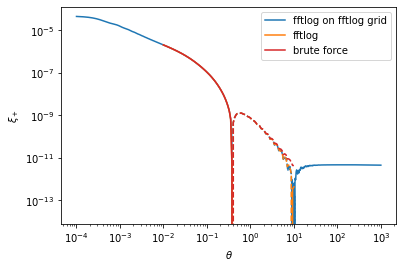

fftlog:1.0643870830535889 sec


In [102]:
t = np.logspace(-2, 1, 100)
with hsc3x2pt.Time(message='brute force'):
    ans = pk2cl.angular_correlation_function_bruteforce('s1', 's1', t, 'xi+')
with hsc3x2pt.Time(message='fftlog'):
    ans = pk2cl.angular_correlation_function_fftlog('s1', 's1', t, 'xi+', plot=True, 
                                                    plot_with=[{'xy':[t,ans],'c':'C3','label':'brute force'}])

brute force:0.0896918773651123 sec
-4.0 3.0


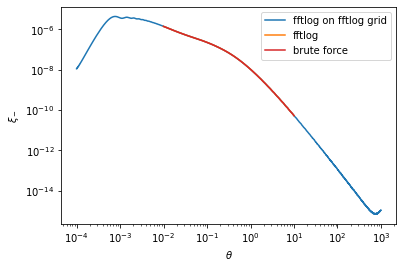

fftlog:0.9248020648956299 sec


In [103]:
t = np.logspace(-2, 1, 100)
with hsc3x2pt.Time(message='brute force'):
    ans = pk2cl.angular_correlation_function_bruteforce('s1', 's1', t, 'xi-')
with hsc3x2pt.Time(message='fftlog'):
    ans = pk2cl.angular_correlation_function_fftlog('s1', 's1', t, 'xi-', plot=True, 
                                                    plot_with=[{'xy':[t,ans],'c':'C3','label':'brute force'}])

### covariance matrices

using dark_emulator at  /Users/sugiyamasunao/Documents/python_package/dark_emulator_public/dark_emulator/__init__.py
1000 1000
(1000, 1000)
1000 1000
0.02325843528276829 0.02325843528276829


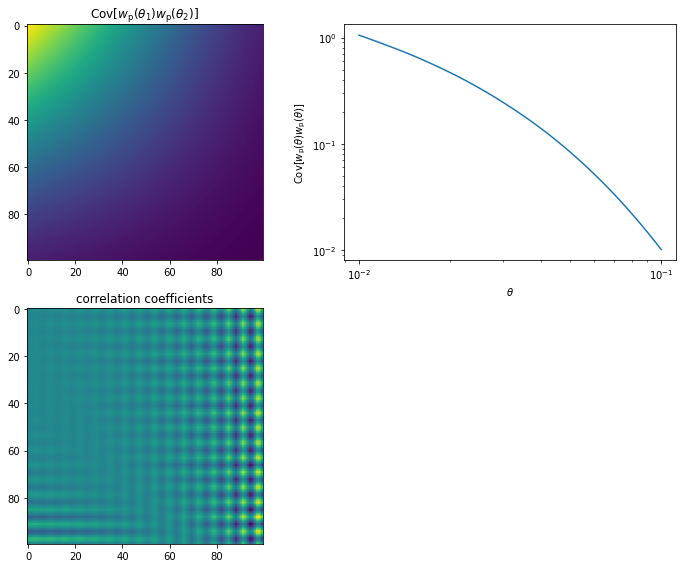

CPU times: user 2.51 s, sys: 112 ms, total: 2.62 s
Wall time: 1.49 s


In [41]:
%%time
t = np.logspace(-2, -1, 100)
cov = pk2cl.covariance_fftlog(['l1','l1'], 'wp', t, ['l1', 'l1'], 'wp', t, binave=True, plot=True)

1000 1000
(1000, 1000)
1000 1000
0.02325843528276829 0.02325843528276829


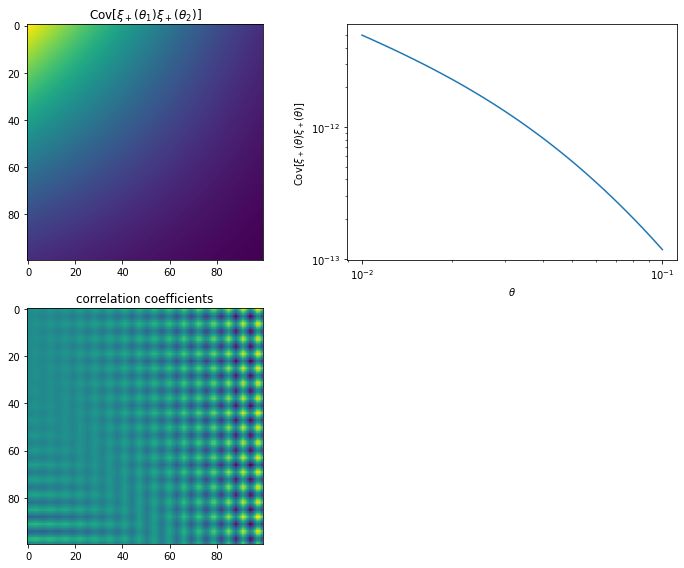

CPU times: user 1.97 s, sys: 186 ms, total: 2.15 s
Wall time: 2.31 s


In [43]:
%%time
t = np.logspace(-2, -1, 100)
cov = pk2cl.covariance_fftlog(['s1','s1'], 'xi+', t, ['s1', 's1'], 'xi+', t, binave=True, plot=True)

1000 1000
(1000, 1000)
1000 1000
0.02325843528276829 0.02325843528276829


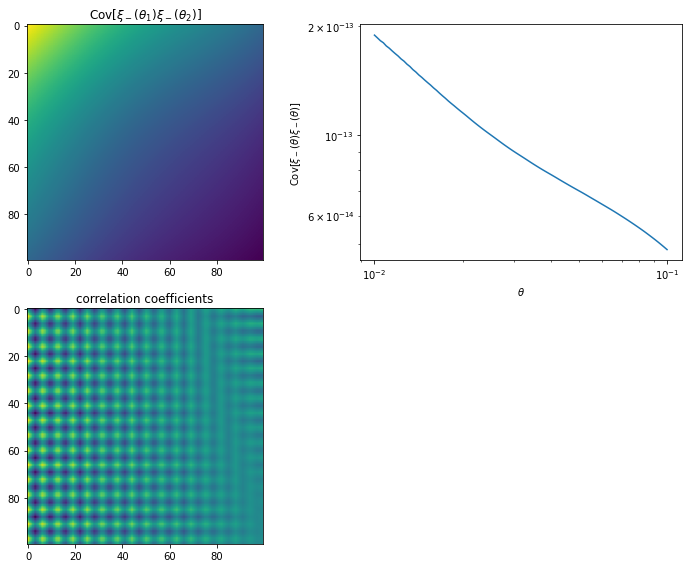

CPU times: user 2.74 s, sys: 199 ms, total: 2.94 s
Wall time: 1.62 s


In [44]:
%%time
t = np.logspace(-2, -1, 100)
cov = pk2cl.covariance_fftlog(['s1','s1'], 'xi-', t, ['s1', 's1'], 'xi-', t, binave=True, plot=True)

1000 1000
(1000, 1000)
1000 1000
0.02325843528276829 0.02325843528276829


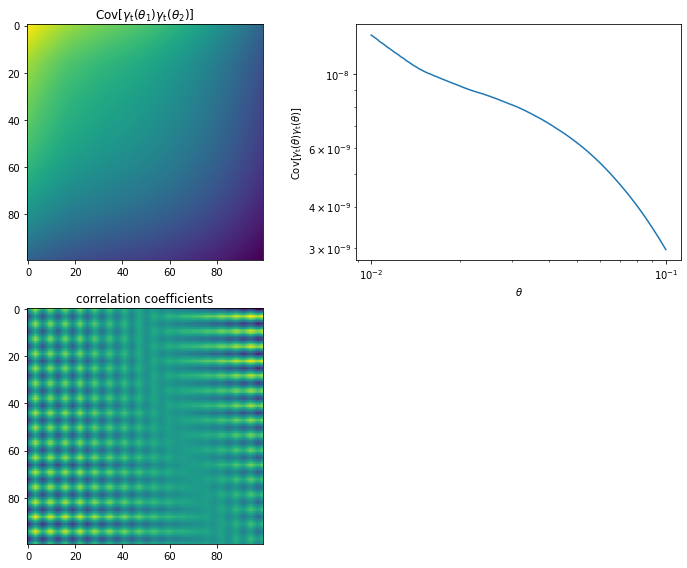

CPU times: user 2.81 s, sys: 251 ms, total: 3.06 s
Wall time: 1.68 s


In [45]:
%%time
t = np.logspace(-2, -1, 100)
cov = pk2cl.covariance_fftlog(['l1','s1'], 'gamma_t', t, ['l1','s1'], 'gamma_t', t, binave=True, plot=True)